In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm,skew #for some statistics
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import warnings
warnings.filterwarnings('ignore')

**Loading Data**

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.shape,test_df.shape

((1460, 81), (1459, 80))

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Basic EDA and statistical analysis**

In [5]:
train_df.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [6]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [8]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [9]:
#Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

In [10]:
#'Id' colum since it's unnecessary for  the prediction process.
train_df.drop('Id',axis=1,inplace = True)
test_df.drop('Id',axis=1,inplace = True)

In [11]:
print('Train data size :',train_df.shape)
print('Test data size :',test_df.shape)

Train data size : (1460, 80)
Test data size : (1459, 79)


**Dealing with outliers**

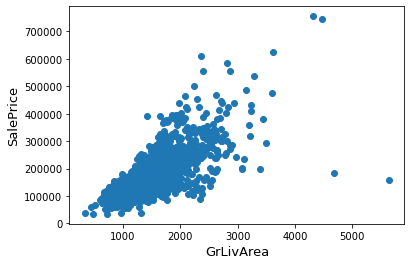

In [12]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'],y = train_df['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()

* We can see that there are outlinear with low SalePrice and high GrLivArea. This looks odd. We need to remove it.

In [13]:
#Deleting outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

**Correlation Analysis**

<AxesSubplot:>

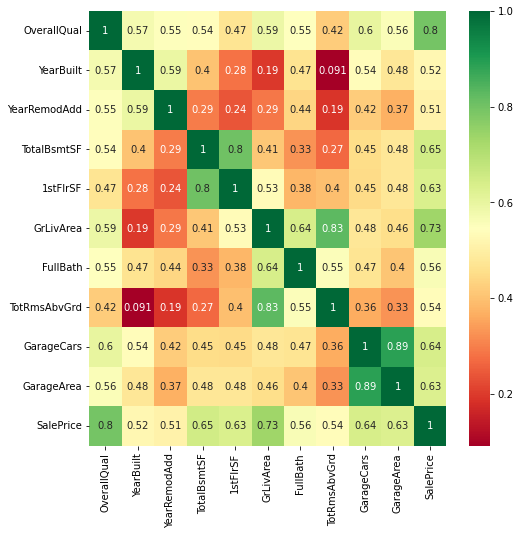

In [14]:
# most correlated features
corrmat = train_df.corr()
top_corr_features = corrmat.index[abs(corrmat['SalePrice'])>0.5]
plt.figure(figsize=(8,8))
sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap='RdYlGn')

* From this we can tell which features **(OverallQual, GrLivArea and TotalBsmtSF )** are highly positively correlated with the SalePrice.
* **GarageCars and GarageArea** also seems correlated with other, Since the no. of car that will fit into the garage will depend on GarageArea.

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

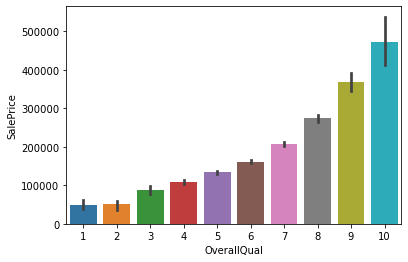

In [15]:
sns.barplot(train_df.OverallQual,train_df.SalePrice)

In [16]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

**Scatter plots between 'SalePrice' and correlated variables**

In [17]:
top_corr_features = corrmat.index[abs(corrmat['SalePrice'])>0.5]
top_corr_features

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')

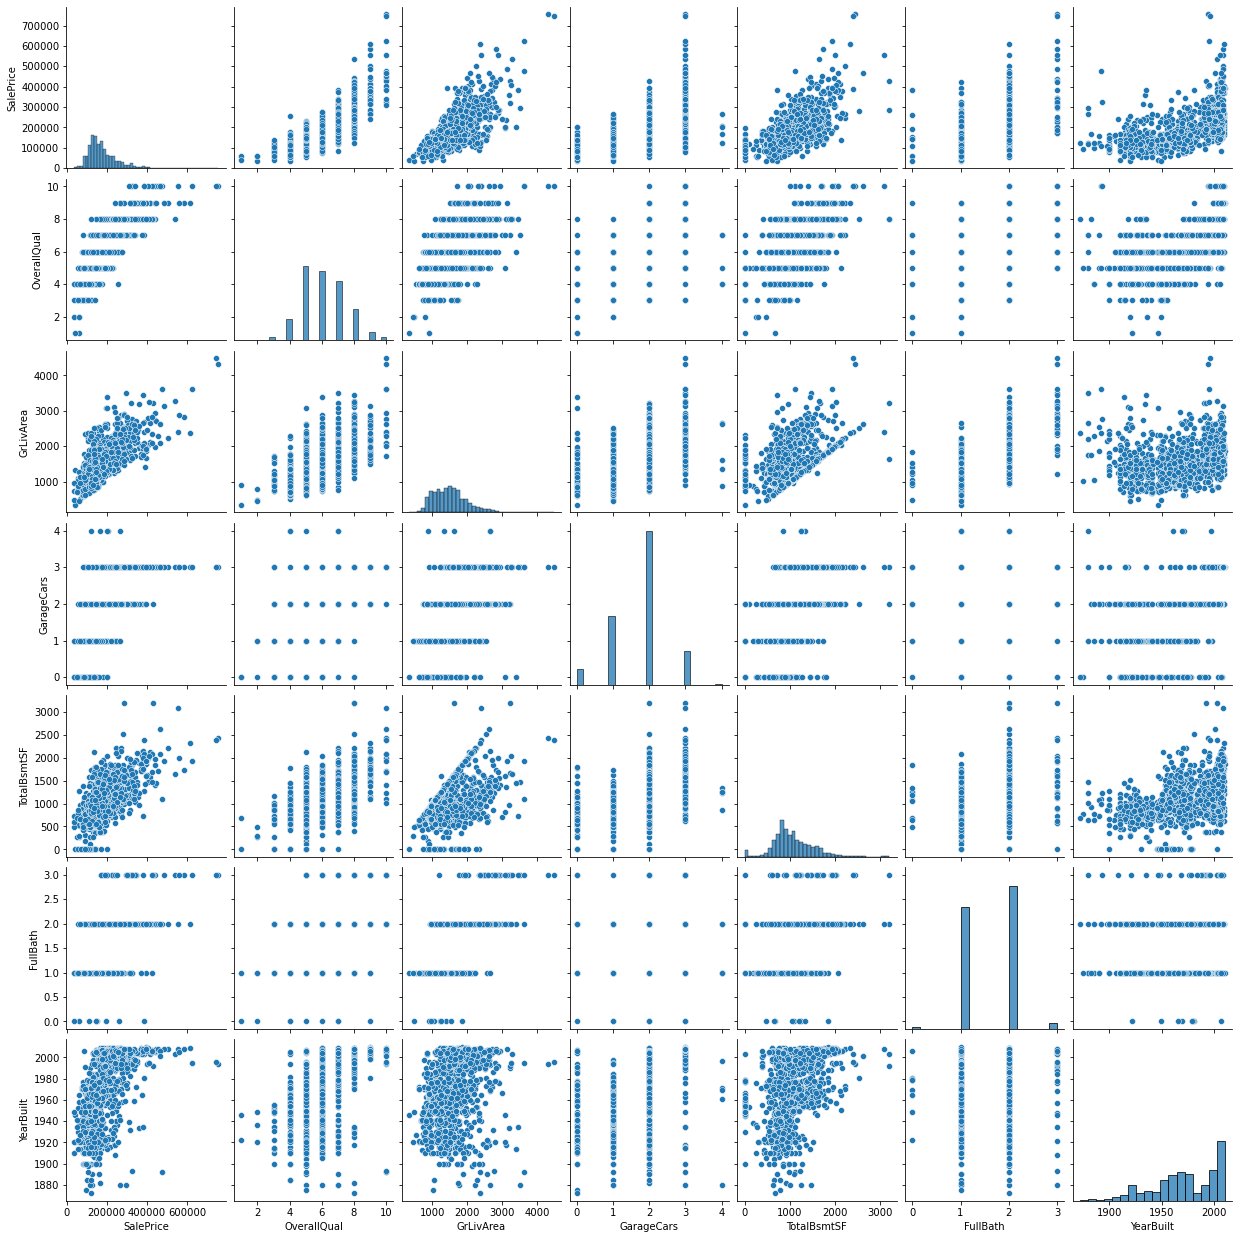

In [18]:
cols = ['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']
sns.pairplot(train_df[cols],size=2.5)

* One of the figures we may find interesting is the one between **'TotalBsmtSF'** and **'GrLiveArea'**

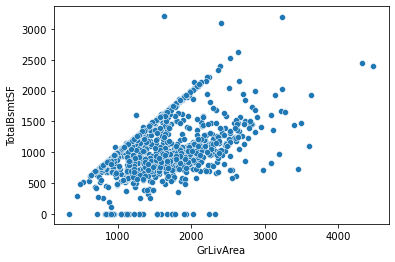

In [19]:
sns.scatterplot(train_df.GrLivArea,train_df.TotalBsmtSF);

**Target Variable Transform**

Different features in the data set may have values in different ranges. For example, in this data set, the range of SalePrice feature may lie from thousands to lakhs but the range of values of YearBlt feature will be in thousands. That means a column is more weighted compared to other.

**Lets check the skewness of data**


 mu=180932.92 and sigma=79467.79



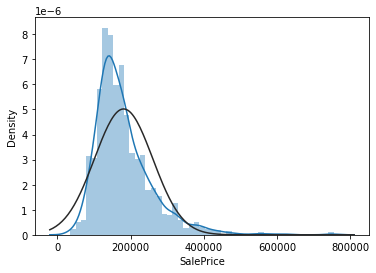

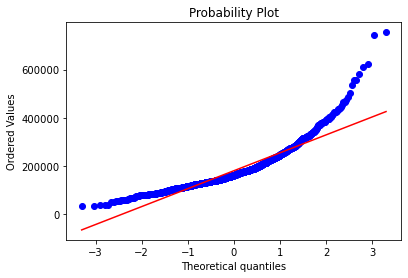

In [20]:
def check_skewness(col):
    sns.distplot(train_df[col],fit=norm)
    fig = plt.figure()
    res = stats.probplot(train_df[col],plot=plt)
    # Get the fitted parameters used by the function
    (mu,sigma) = norm.fit(train_df[col])
    print('\n mu={:.2f} and sigma={:.2f}\n'.format(mu,sigma))
    
check_skewness('SalePrice')

* **This distribution is positively skewed.** Notice that the black curve is more deviated towards the right.It is recommended to fix the skewness to make good decisions by the model.

* The best way to fix it is to perform a **log transform** of the same data, with the intent to reduce the skewness.


 mu=12.02 and sigma=0.40



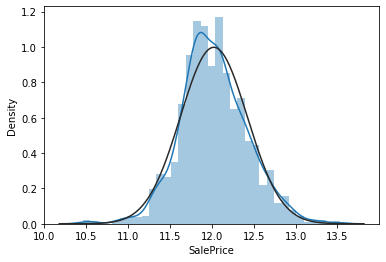

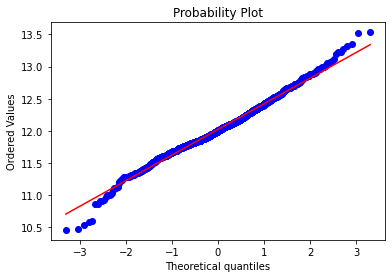

In [21]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
check_skewness('SalePrice')

* After taking logarithm of the same data the curve seems to be normally distributed, although not perfectly normal, this is sufficient to fix the issues from a skewed dataset as we saw before.


**Feature Engineering**

In [22]:
ntrain_df = train_df.shape[0]
ntest_df = test_df.shape[0]
y_train = train_df.SalePrice.values
all_data = pd.concat((train_df,test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace =True)
all_data.shape

(2917, 79)

In [23]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


**Missing Data**

In [24]:
all_data.isna().sum()

MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 79, dtype: int64

In [25]:
all_data_na = (all_data.isna().sum()/all_data.isna().count())*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0 ].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})

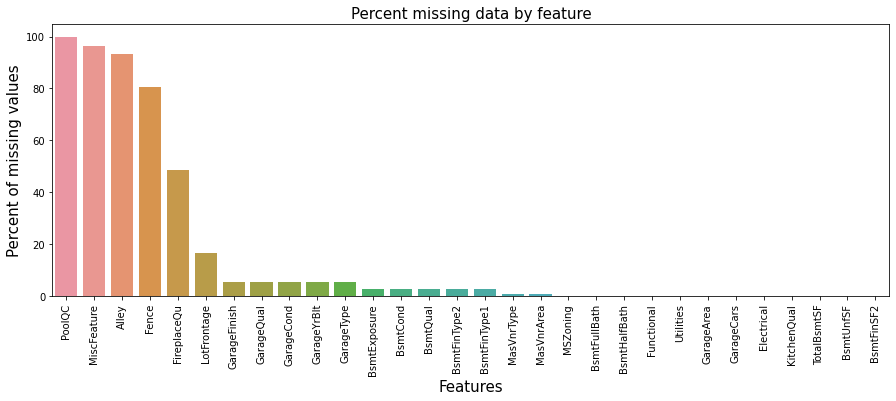

In [26]:
f, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=all_data_na.index,y=all_data_na)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);

In [27]:
all_data.PoolQC.loc[all_data.PoolQC.notnull()]

197     Ex
809     Fa
1169    Gd
1181    Ex
1384    Fa
1421    Gd
1972    Ex
2571    Ex
2708    Gd
Name: PoolQC, dtype: object

**GarageType, GarageFinish, GarageQual, GarageCond, GarageYrBlt, GarageArea, GarageCars these all features have same percentage of null values.**

**Handle Missing Data**

* Since PoolQC has the highest null values according to the data documentation says **null values means 'No Pool.** Since majority of houses has no pool. So we will replace those null values with 'None'.

In [28]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [29]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')


* **MiscFeature:** Data documentation says NA means "no misc feature"

In [30]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

* **Alley:** Data description says NA means "no alley access"

In [31]:
all_data['Alley'] = all_data['Alley'].fillna('None')

* **Fence:** Data description says NA means "no fence"

In [32]:
all_data['Fence'] = all_data['Fence'].fillna('None')

* **FireplaceQu:** data description says NA means "no fireplace"

In [33]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

* **LotFrontage:** Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [34]:
# Grouping by Neighborhood and Check the LotFrontage. Most of the grouping has similar areas
grouped_df = all_data.groupby('Neighborhood')['LotFrontage']

for key, item in grouped_df:
    print(key, '\n')
    print(grouped_df.get_group(key))
    break

Blmngtn 

219     43.0
229     43.0
385     43.0
443     53.0
465      NaN
558      NaN
596     53.0
638     53.0
789     43.0
850      NaN
981     43.0
1003    43.0
1018    43.0
1022    43.0
1125    53.0
1392    53.0
1413    51.0
1481    43.0
1683    43.0
1982     NaN
1983     NaN
1984    53.0
2318     NaN
2319    53.0
2669    43.0
2670     NaN
2671     NaN
2672    43.0
Name: LotFrontage, dtype: float64


In [35]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

* **GarageType, GarageFinish, GarageQual and GarageCond:** Replacing missing data with None as per documentation.

In [36]:
for col in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    all_data[col]=all_data[col].fillna('None')

abc = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt', 'GarageArea', 'GarageCars']
all_data.groupby('GarageType')[abc].count()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageArea,GarageCars
GarageType,,,,,,,
2Types,23,23,23,23,23,23,23
Attchd,1722,1722,1722,1722,1722,1722,1722
Basment,36,36,36,36,36,36,36
BuiltIn,185,185,185,185,185,185,185
CarPort,15,15,15,15,15,15,15
Detchd,779,779,779,779,777,778,778
None,157,157,157,157,0,157,157


* **GarageYrBlt, GarageArea and GarageCars:** Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [37]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath:** missing values are likely zero for having no basement

In [38]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

* **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 :** For all these categorical basement-related features, NaN means that there is no basement.

In [39]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

* **MasVnrArea and MasVnrType :** NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [40]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna('None')
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

* **MSZoning (The general zoning classification) :** 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [41]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [42]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

* **Utilities :** Since this is a categorical data and most of the data are of same category, Its not gonna effect on model. So we choose to drop it.

In [43]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [44]:
all_data = all_data.drop('Utilities',axis=1)

* **Functional :** Data description says NA means typical

In [45]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

* **Electrical,KitchenQual, Exterior1st, Exterior2nd, SaleType :** Since this all are categorical values so its better to replace nan values with the most used keyword.

In [46]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

* **MSSubClass :** Na most likely means No building class. We can replace missing values with None

In [47]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

**Lets check for any missing values**

In [48]:
#Check remaining missing values if any
all_data_na = (all_data.isna().sum()/all_data.isna().count()) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head()

,Missing Ratio


In [49]:
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

**Converting some numerical variables that are really categorical type.**

In [50]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**Label Encoding**

In [51]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond','ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 
        'KitchenQual', 'BsmtFinType1','BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond','YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

#Shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


* Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [52]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**Lets see the highly skewed features we have**

In [53]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'skew': skewed_feats})
skewness.head(15)


Skew in numerical features: 



,skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


**Box Cox Transformation of (highly) skewed features**

When you are dealing with real-world data, you are going to deal with features that are heavily skewed. Transformation technique is useful to **stabilize variance**, make the data more **normal distribution-like**, improve the validity of measures of association.

The problem with the Box-Cox Transformation is **estimating lambda.** This value will depend on the existing data, and should be considered when performing cross validation on out of sample datasets.

In [54]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewness_features = skewness.index
lam = 0.15
for feat in skewness_features:
    all_data[feat] = boxcox1p(all_data[feat],lam)

There are 59 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

In [55]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

In [56]:
train = all_data[:ntrain_df]
test = all_data[ntrain_df:]
train.shape

(1458, 220)

**Applying Modelling**

In [57]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds,shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values,y_train,scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

**Modelling**

**Ridge Regression**
* It shrinks the parameters, therefore it is mostly used to prevent multicollinearity.
* It reduces the model complexity by coefficient shrinkage.
* It uses L2 regularization technique.

In [58]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



**Lasso Regression**

LASSO (Least Absolute Shrinkage Selector Operator), is quite similar to ridge.

In case of lasso, even at smaller alpha’s, our coefficients are reducing to absolute zeroes. Therefore, lasso selects the only some feature while reduces the coefficients of others to zero. This property is known as feature selection and which is absent in case of ridge.

* Lasso uses L1 regularization technique.
* Lasso is generally used when we have more number of features, because it automatically does feature selection.

In [59]:
lasso = make_pipeline(RobustScaler(),Lasso(alpha = 0.0005,random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1115 (0.0074)



**Elastic Net Regression**

Elastic net is basically a combination of both L1 and L2 regularization. So if you know elastic net, you can implement both Ridge and Lasso by tuning the parameters.

In [60]:
ENet = make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



**Gradient Boosting Regression**

In [61]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4,max_features='sqrt',min_samples_leaf=15,
                                  min_samples_split=10,loss='huber',random_state=5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



**Fit the training dataset on every model**

In [62]:
LassoMd = lasso.fit(train.values,y_train)
ENetMd = ENet.fit(train.values,y_train)
KRRMd = KRR.fit(train.values,y_train)
GBoostMd = GBoost.fit(train.values,y_train)

**Mean of all model's prediction.**

np.expm1 ( ) is used to calculate exp(x) - 1 for all elements in the array.

In [63]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(ENetMd.predict(test.values)) + np.expm1(KRRMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values)) ) / 4
finalMd

array([119948.0122342 , 162155.60705468, 187347.79365514, ...,
       172794.6519192 , 115309.38793785, 220724.08743706])

**Submission**

In [64]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
sub.to_csv('submission.csv',index=False)